In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt

import glob
import xarray as xr
import datetime

In [2]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


In [4]:
dtype = torch.complex64  # fft required data type

In [5]:
def torch_holo_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

# Pick the Dataset

In [6]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [7]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [8]:
f_sel = 40
dataFile = file_list[f_sel]

In [9]:
h_ds = xr.open_dataset(dataFile)

# Build Histogram For Labels

In [10]:
n_bins = 100  # number of bins in histogram
n_holograms = 1000  # number of holograms to use in data set
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers
hologram_slice = slice(None,2*n_holograms)

In [11]:
histogram_lst = []
for holo_idx in h_ds['hologram_number'].values[hologram_slice]:
    hist_tpl = np.histogram(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],bins=z_bins)
    histogram_lst.append(hist_tpl[0])

Text(0.5, 0, 'z position [$\\mu m$]')

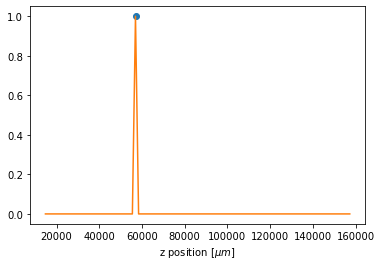

In [12]:
# confirm histogram and particle data are aligned
plt.figure()
plt.plot(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],np.ones(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)].shape),'o')
plt.plot(z_centers,histogram_lst[holo_idx])
plt.xlabel('z position [$\mu m$]')

In [13]:
histogram_arr = np.stack(histogram_lst,axis=0)
train_histogram_bin_arr = (histogram_arr[:n_holograms,:]>0).astype(float)
valid_histogram_bin_arr = (histogram_arr[n_holograms:,:]>0).astype(float)

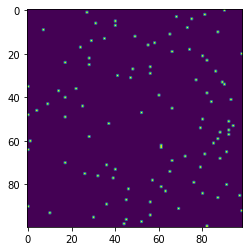

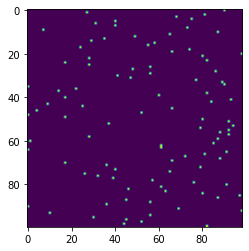

In [14]:
plt.figure()
plt.imshow(histogram_arr[0:100,:])
plt.figure()
plt.imshow(train_histogram_bin_arr[0:100,:])

# Build Reconstructed Plane Inputs

In [15]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [16]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [17]:
fx = torch.fft.fftfreq(Nx,dx,device=device)[None,:,None]
fy = torch.fft.fftfreq(Ny,dy,device=device)[None,None,:]
z_rec = torch.tensor(z_centers*1e-6,device=device)[:,None,None]

Test Reconstruction Assumptions

(1, 600, 400)
(600,)
(400,)


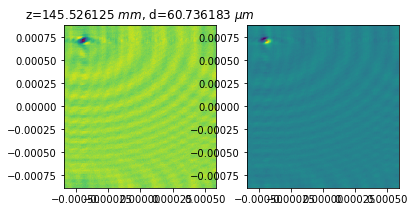

In [18]:
holo_idx = 0
p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
xp = h_ds['x'].values[p_idx]
yp = h_ds['y'].values[p_idx]
zp = h_ds['z'].values[p_idx]
dp = h_ds['d'].values[p_idx]
z_plane = torch.tensor(zp*1e-6,device=device)[:,None,None]
E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
Eres = torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

print(Eres.shape)
print(x_arr.shape)
print(y_arr.shape)

for idx,z in enumerate(zp):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    ax[0].pcolormesh(y_arr,x_arr,np.abs(Eres[idx,:,:]))
    ax[0].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)
    ax[0].set_title('z=%f $mm$, d=%f $\mu m$'%(z*1e-3,dp[idx]))
    ax[1].pcolormesh(y_arr,x_arr,np.angle(Eres[idx,:,:]))
    ax[1].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)

In [19]:
Eset1 = []
Eset2 = []
histset = []
start_time = datetime.datetime.now()
for holo_idx in range(2*n_holograms):
    part_idx = np.where(histogram_arr[holo_idx,:] > 0)[0]
    empt_idx = np.where(histogram_arr[holo_idx,:] == 0)[0]
    set_part = np.random.choice(part_idx, num_per_holo ,replace=False)
    set_empt = np.random.choice(empt_idx, num_per_holo ,replace=False)
    z_rec_sub = torch.tensor(1e-6*z_centers[np.concatenate([set_part,set_empt])],device=device)[:,None,None]
    image_in = h_ds['image'].isel(hologram_number=holo_idx).values
    image_in = image_in/image_in.max()
    E_input = torch.tensor(image_in,device=device,dtype=dtype)[None,:,:] 
    Eres = torch_holo_set(E_input,fx,fy,z_rec_sub,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))
    Eset1.append(Eres[:,None,:,:].abs())
    Eset2.append(Eres[:,None,:,:].angle())
    histset.append(histogram_arr[holo_idx,np.concatenate([set_part,set_empt])])

#     # Include All Reconstructions
#     E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
#     Eres = torch_holo_set(E_input,fx,fy,z_rec,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.abs(),Eres.angle()],dim=1))
#     # Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))


end_time = datetime.datetime.now()

In [20]:
exec_time = end_time-start_time
print(f'executed {2*num_per_holo*len(Eset1)} planes in {exec_time.total_seconds()} seconds')
print(f' for {exec_time.total_seconds()/(2*num_per_holo*len(Eset1))} seconds per plane')

# exec_time = end_time-start_time
# print(f'executed {z_centers.size*len(Eset)} planes in {exec_time.total_seconds()} seconds')
# print(f' for {exec_time.total_seconds()/(z_centers.size*len(Eset))} seconds per plane')

executed 4000 planes in 38.43879 seconds
 for 0.0096096975 seconds per plane


In [21]:
idx_arr = np.arange(len(Eset1)).astype(int)
train_idx = np.random.choice(idx_arr, idx_arr[-1]//2 ,replace=False)
valid_idx = np.delete(idx_arr,train_idx)

In [22]:
train_inputs1 = torch.cat(Eset1,dim=0)[train_idx,:,:,:]
valid_inputs1 = torch.cat(Eset1,dim=0)[valid_idx,:,:,:]
train_inputs2 = torch.cat(Eset2,dim=0)[train_idx,:,:,:]/np.pi
valid_inputs2 = torch.cat(Eset2,dim=0)[valid_idx,:,:,:]/np.pi

In [23]:
hist_labels = np.concatenate(histset)

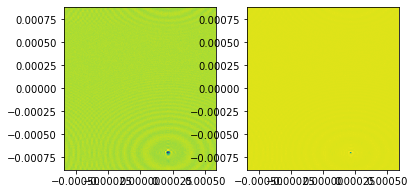

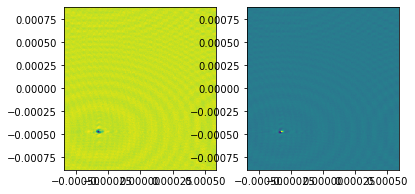

In [24]:
idx = np.where(hist_labels[train_idx]>0)[0][84]
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].pcolormesh(y_arr,x_arr,train_inputs1[idx,0,:,:])
ax[1].pcolormesh(y_arr,x_arr,train_inputs2[idx,0,:,:])


idx = np.where(hist_labels[valid_idx]>0)[0][4]
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].pcolormesh(y_arr,x_arr,valid_inputs1[idx,0,:,:])
ax[1].pcolormesh(y_arr,x_arr,valid_inputs2[idx,0,:,:])

In [25]:
train_inputs1.max()

tensor(1.1463, dtype=torch.float64)

# Build Model

In [26]:
epochs = 300
optimizer_type = "adam"
learning_rate = 1e-8
batch_size = 2
dtype = torch.float

In [27]:
# train_labels = torch.tensor(train_histogram_bin_arr.reshape(-1,1),dtype=dtype)
# valid_labels = torch.tensor(valid_histogram_bin_arr.reshape(-1,1),dtype=dtype)

# ### TODO ###
train_labels = torch.tensor(hist_labels[train_idx],dtype=dtype)[:,None]
valid_labels = torch.tensor(hist_labels[valid_idx],dtype=dtype)[:,None]

In [28]:
train_labels.shape

torch.Size([999, 1])

In [29]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()

In [30]:
input_shape = train_inputs1.shape[1:]
output_shape = train_labels.shape[1:]
print(input_shape)
print(output_shape)

torch.Size([1, 600, 400])
torch.Size([1])


In [31]:
# ResNet 50 notebook : /glade/work/schreck/repos/goes16ci/gunther_notebook/latest.ipynb

class z_plane_histogram_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv11 = nn.Conv2d(1, 32, 7)
        self.conv12 = nn.Conv2d(32, 64, 7)
        
        self.conv21 = nn.Conv2d(1, 32, 7)
        self.conv22 = nn.Conv2d(32, 64, 7)
        
        self.pool = nn.MaxPool2d(4, 4)
        
        self.fc1 = nn.Linear(2*64*35*23, 120)
        self.fc2 = nn.Linear(120, 1)
#         self.fc3 = nn.Linear(84, 1)

    def forward(self, x1, x2):
        x1 = self.pool(F.relu(self.conv11(x1)))
        x1 = self.pool(F.relu(self.conv12(x1)))
        
        x2 = self.pool(F.relu(self.conv21(x2)))
        x2 = self.pool(F.relu(self.conv22(x2)))
#         print(x1.shape)
        x = torch.cat([torch.flatten(x1,1),torch.flatten(x2,1)],dim=1)
#         print(x.shape)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))
        return x
    


In [32]:
cnn_model = z_plane_histogram_cnn()
cnn_model.to(device)

z_plane_histogram_cnn(
  (conv11): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv12): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv21): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv22): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=103040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
)

In [33]:
if optimizer_type == "adam":
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
elif optimizer_type == "sgd":
    optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)
else:
    logging.warning(
        f"Optimzer type {optimizer_type} is unknown. Exiting with error."
    )

In [34]:
train_ds = TensorDataset(train_inputs1.float().to(device), train_inputs2.float().to(device), train_labels.float().to(device))
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

valid_ds = TensorDataset(valid_inputs1.float().to(device), valid_inputs2.float().to(device), valid_labels.float().to(device))
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [35]:
train_loss_hist = []
valid_loss_hist = []

In [83]:
epochs=500

In [36]:
batches_per_epoch = len(train_dl)+1


for epoch in range(epochs):
    train_loss = 0
    cnn_model.train()
    for batch_idx,(xb1,xb2,yb) in tqdm.tqdm(enumerate(train_dl),total=batches_per_epoch,leave=True):
        pred = cnn_model(xb1,xb2)
        loss = loss_fn(pred, yb)
        train_loss += loss.sum().to('cpu').item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        cnn_model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(cnn_model(xb1,xb2), yb) for xb1, xb2, yb in valid_dl)

    train_loss_hist += [train_loss / len(train_dl)]
    valid_loss_hist += [valid_loss.item() / len(valid_dl)]
    print(epoch, train_loss / len(train_dl), valid_loss.item() / len(valid_dl))

  2%|▏         | 12/500 [00:00<00:04, 109.98it/s]

0 0.6932831318378448 0.6932126957023453


  2%|▏         | 12/500 [00:00<00:04, 110.04it/s]

1 0.6932455726861954 0.6931808989442989


  2%|▏         | 12/500 [00:00<00:04, 109.94it/s]

2 0.693194452881813 0.6931194983080714


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

3 0.6931000119447708 0.6930548692653755


  2%|▏         | 12/500 [00:00<00:04, 109.85it/s]

4 0.6930671514272689 0.6930256917805016


  2%|▏         | 12/500 [00:00<00:04, 110.05it/s]

5 0.6930091527700424 0.6929842707163797


  2%|▏         | 12/500 [00:00<00:04, 110.30it/s]

6 0.6929427968263626 0.692941509559007


  2%|▏         | 12/500 [00:00<00:04, 110.11it/s]

7 0.6928913186788559 0.6929161087005676


  2%|▏         | 12/500 [00:00<00:04, 109.88it/s]

8 0.6928407261371613 0.6928910124087762


  2%|▏         | 12/500 [00:00<00:04, 109.78it/s]

9 0.6928519557714462 0.6928500177379616


  2%|▏         | 12/500 [00:00<00:04, 109.94it/s]

10 0.6927931747436523 0.6928279061993201


  2%|▏         | 12/500 [00:00<00:04, 110.07it/s]

11 0.6927297769784927 0.6927997033277196


  2%|▏         | 12/500 [00:00<00:04, 110.01it/s]

12 0.6927320866584777 0.6927775308757484


  2%|▏         | 12/500 [00:00<00:04, 109.91it/s]

13 0.6926990180015564 0.6927546274638223


  2%|▏         | 12/500 [00:00<00:04, 110.01it/s]

14 0.6926422156095505 0.6927442721977919


  2%|▏         | 12/500 [00:00<00:04, 110.09it/s]

15 0.6926332458257675 0.6927250844989709


  2%|▏         | 12/500 [00:00<00:04, 109.98it/s]

16 0.692616991519928 0.692706140453468


  2%|▏         | 12/500 [00:00<00:04, 109.83it/s]

17 0.6925603293180466 0.6926909730344


  2%|▏         | 12/500 [00:00<00:04, 110.03it/s]

18 0.6925045976638794 0.6926814705549837


  2%|▏         | 12/500 [00:00<00:04, 110.23it/s]

19 0.6924890315532685 0.6926653894359718


  2%|▏         | 12/500 [00:00<00:04, 109.87it/s]

20 0.6924570475816727 0.692654790516623


  2%|▏         | 12/500 [00:00<00:04, 109.99it/s]

21 0.692428344130516 0.6926377956976671


  2%|▏         | 12/500 [00:00<00:04, 109.86it/s]

22 0.6924082772731781 0.6926310952314122


  2%|▏         | 12/500 [00:00<00:04, 110.10it/s]

23 0.6923980890512467 0.6926163542056512


  2%|▏         | 12/500 [00:00<00:04, 109.79it/s]

24 0.6923798640966415 0.6926128821458645


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

25 0.6923551557064056 0.6926080090794973


  2%|▏         | 12/500 [00:00<00:04, 109.73it/s]

26 0.692293099284172 0.6926016131798902


  2%|▏         | 12/500 [00:00<00:04, 109.95it/s]

27 0.6922585445642472 0.6925959482402383


  2%|▏         | 12/500 [00:00<00:04, 109.71it/s]

28 0.6923155586719513 0.692584374707616


  2%|▏         | 12/500 [00:00<00:04, 109.71it/s]

29 0.6922614681720733 0.6925720702150386


  2%|▏         | 12/500 [00:00<00:04, 110.33it/s]

30 0.692230188369751 0.6925745676615519


  2%|▏         | 12/500 [00:00<00:04, 110.59it/s]

31 0.692184799194336 0.6925644560488399


  2%|▏         | 12/500 [00:00<00:04, 110.39it/s]

32 0.69217253947258 0.6925603748557573


  2%|▏         | 12/500 [00:00<00:04, 110.05it/s]

33 0.6921458963155747 0.692547461229884


  2%|▏         | 12/500 [00:00<00:04, 110.50it/s]

34 0.692136466383934 0.6925454510900075


  2%|▏         | 12/500 [00:00<00:04, 110.67it/s]

35 0.6921558283567428 0.6925382024037862


  2%|▏         | 12/500 [00:00<00:04, 110.72it/s]

36 0.6920854421854019 0.6925301009309506


  2%|▏         | 12/500 [00:00<00:04, 110.51it/s]

37 0.6921091022491455 0.6925234613780252


  2%|▏         | 12/500 [00:00<00:04, 110.63it/s]

38 0.692097464799881 0.692517979178362


  2%|▏         | 12/500 [00:00<00:04, 110.31it/s]

39 0.6920266497135162 0.6925152380785304


  2%|▏         | 12/500 [00:00<00:04, 110.24it/s]

40 0.6920275505781174 0.692510974145459


  2%|▏         | 12/500 [00:00<00:04, 110.29it/s]

41 0.692051282286644 0.6925048828125


  2%|▏         | 12/500 [00:00<00:04, 110.21it/s]

42 0.6920041964054108 0.6924941011531625


  2%|▏         | 12/500 [00:00<00:04, 110.28it/s]

43 0.6919527465105056 0.6924923346666043


  2%|▏         | 12/500 [00:00<00:04, 110.35it/s]

44 0.6919926863908767 0.6925039691125562


  2%|▏         | 12/500 [00:00<00:04, 110.03it/s]

45 0.6919148527383804 0.6924876443402258


  2%|▏         | 12/500 [00:00<00:04, 110.30it/s]

46 0.6919000712633133 0.6924849641537238


  2%|▏         | 12/500 [00:00<00:04, 109.77it/s]

47 0.6918991602659226 0.6924798474340381


  2%|▏         | 12/500 [00:00<00:04, 109.88it/s]

48 0.6919171390533447 0.692482405793881


  2%|▏         | 12/500 [00:00<00:04, 109.72it/s]

49 0.6918942960500717 0.6924821012272331


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

50 0.6919117456674576 0.6924911164000125


  2%|▏         | 12/500 [00:00<00:04, 109.92it/s]

51 0.6918263428211212 0.6924733906211016


  2%|▏         | 12/500 [00:00<00:04, 109.95it/s]

52 0.691818200469017 0.6924746088876934


  2%|▏         | 12/500 [00:00<00:04, 109.74it/s]

53 0.6918237503767014 0.6924817966605851


  2%|▏         | 12/500 [00:00<00:04, 110.18it/s]

54 0.6917632485628128 0.6924677256814497


  2%|▏         | 12/500 [00:00<00:04, 110.21it/s]

55 0.6917919023036957 0.6924662028482098


  2%|▏         | 12/500 [00:00<00:04, 110.07it/s]

56 0.691726266503334 0.6924595632952845


  2%|▏         | 12/500 [00:00<00:04, 109.90it/s]

57 0.6917144002914428 0.6924674211148016


  2%|▏         | 12/500 [00:00<00:04, 109.77it/s]

58 0.6917372779846191 0.6924664465015282


  2%|▏         | 12/500 [00:00<00:04, 110.23it/s]

59 0.6917049976587295 0.6924536547023141


  2%|▏         | 12/500 [00:00<00:04, 109.68it/s]

60 0.6917061220407486 0.6924529846556886


  2%|▏         | 11/500 [00:00<00:04, 109.98it/s]

61 0.6917033007144928 0.6924507917758234


  2%|▏         | 11/500 [00:00<00:04, 109.88it/s]

62 0.69160415828228 0.6924580404620446


  2%|▏         | 12/500 [00:00<00:04, 109.65it/s]

63 0.6916568953990936 0.6924534110489957


  2%|▏         | 12/500 [00:00<00:04, 109.67it/s]

64 0.6916231961250305 0.6924507308624938


  2%|▏         | 12/500 [00:00<00:04, 110.08it/s]

65 0.6915496790409088 0.6924517054757672


  2%|▏         | 12/500 [00:00<00:04, 110.21it/s]

66 0.69156989133358 0.692456944022112


  2%|▏         | 12/500 [00:00<00:04, 109.87it/s]

67 0.6915235507488251 0.692448903462606


  2%|▏         | 12/500 [00:00<00:04, 109.71it/s]

68 0.6915477517843246 0.6924437867429204


  2%|▏         | 12/500 [00:00<00:04, 109.83it/s]

69 0.691575847029686 0.6924515227357785


  2%|▏         | 12/500 [00:00<00:04, 109.71it/s]

70 0.6915401896238327 0.6924431776096245


  2%|▏         | 12/500 [00:00<00:04, 110.18it/s]

71 0.6915309590101242 0.69245426383561


  2%|▏         | 12/500 [00:00<00:04, 110.14it/s]

72 0.6913544163703919 0.6924529846556886


  2%|▏         | 12/500 [00:00<00:04, 109.78it/s]

73 0.6914832277297973 0.6924496953358907


  2%|▏         | 12/500 [00:00<00:04, 110.02it/s]

74 0.6914495108127594 0.6924415329497255


  2%|▏         | 12/500 [00:00<00:04, 110.07it/s]

75 0.6914063727855683 0.6924415329497255


  2%|▏         | 12/500 [00:00<00:04, 109.81it/s]

76 0.6914445823431015 0.6924488425492764


  2%|▏         | 12/500 [00:00<00:04, 110.06it/s]

77 0.6913813738822937 0.6924538983556325


  2%|▏         | 12/500 [00:00<00:04, 110.28it/s]

78 0.6914337998628617 0.6924468933227296


  2%|▏         | 12/500 [00:00<00:04, 110.02it/s]

79 0.6913773832321167 0.6924393400698603


  2%|▏         | 12/500 [00:00<00:04, 110.37it/s]

80 0.6913662315607071 0.6924484161559693


  2%|▏         | 12/500 [00:00<00:04, 110.31it/s]

81 0.6913864221572876 0.6924421420830215


  2%|▏         | 12/500 [00:00<00:04, 109.77it/s]

82 0.6913609634637833 0.6924496953358907


  2%|▏         | 12/500 [00:00<00:04, 109.64it/s]

83 0.6913913402557373 0.6924524364357223


  2%|▏         | 12/500 [00:00<00:04, 109.77it/s]

84 0.6912949868440628 0.6924546902289171


  2%|▏         | 12/500 [00:00<00:04, 110.02it/s]

85 0.6913778297901153 0.6924429339563062


  2%|▏         | 12/500 [00:00<00:04, 109.73it/s]

86 0.6912793701887131 0.6924553602755427


  2%|▏         | 12/500 [00:00<00:04, 109.94it/s]

87 0.6913200874328613 0.6924442131362275


  2%|▏         | 12/500 [00:00<00:04, 109.65it/s]

88 0.6912523030042649 0.6924397664631674


  2%|▏         | 12/500 [00:00<00:04, 109.77it/s]

89 0.6912232866287231 0.6924429339563062


  2%|▏         | 11/500 [00:00<00:04, 109.85it/s]

90 0.6912575604915618 0.6924470151493887


  2%|▏         | 12/500 [00:00<00:04, 110.16it/s]

91 0.6912770510911942 0.6924426293896582


  2%|▏         | 12/500 [00:00<00:04, 110.19it/s]

92 0.6912162846326828 0.6924408629031


  2%|▏         | 12/500 [00:00<00:04, 110.58it/s]

93 0.6912315038442611 0.6924417156897144


  2%|▏         | 11/500 [00:00<00:04, 108.69it/s]

94 0.6911793594360351 0.6924482334159805


  2%|▏         | 12/500 [00:00<00:04, 109.86it/s]

95 0.6911614867448806 0.6924621216551272


  2%|▏         | 12/500 [00:00<00:04, 110.15it/s]

96 0.6912045041322709 0.6924517054757672


  2%|▏         | 12/500 [00:00<00:04, 110.38it/s]

97 0.6912031766176224 0.6924739388410679


  2%|▏         | 12/500 [00:00<00:04, 110.55it/s]

98 0.6911661459207534 0.6924595023819549


  2%|▏         | 12/500 [00:00<00:04, 110.48it/s]

99 0.6911400629281997 0.6924571267621008


  2%|▏         | 12/500 [00:00<00:04, 110.19it/s]

100 0.6910971930027008 0.6924644972749813


  2%|▏         | 12/500 [00:00<00:04, 110.00it/s]

101 0.6911336963176727 0.692458893248659


  2%|▏         | 12/500 [00:00<00:04, 111.20it/s]

102 0.6910653692483902 0.6924601115152508


  2%|▏         | 12/500 [00:00<00:04, 109.91it/s]

103 0.69112249147892 0.6924687612080527


  2%|▏         | 12/500 [00:00<00:04, 109.94it/s]

104 0.6910895466804504 0.6924632790083894


  2%|▏         | 12/500 [00:00<00:04, 111.06it/s]

105 0.6910591379404069 0.6924584668553518


  2%|▏         | 11/500 [00:00<00:04, 109.37it/s]

106 0.6911045678853989 0.6924515227357785


  2%|▏         | 12/500 [00:00<00:04, 109.82it/s]

107 0.6910289487838746 0.6924566394554641


  2%|▏         | 12/500 [00:00<00:04, 110.04it/s]

108 0.69104290163517 0.692461268868513


  2%|▏         | 12/500 [00:00<00:04, 109.85it/s]

109 0.6910012698173523 0.6924485988959581


  2%|▏         | 12/500 [00:00<00:04, 109.62it/s]

110 0.6910507937669754 0.6924536547023141


  2%|▏         | 12/500 [00:00<00:04, 109.90it/s]

111 0.6909443883895874 0.6924477461093438


  2%|▏         | 11/500 [00:00<00:04, 109.91it/s]

112 0.6909550613164902 0.6924570658487712


  2%|▏         | 12/500 [00:00<00:04, 109.81it/s]

113 0.6909634224176406 0.6924546293155875


  2%|▏         | 12/500 [00:00<00:04, 110.00it/s]

114 0.6910049517154694 0.6924506090358346


  2%|▏         | 12/500 [00:00<00:04, 110.02it/s]

115 0.6909565246105194 0.6924575531554079


  2%|▏         | 12/500 [00:00<00:04, 109.90it/s]

116 0.6909243906736374 0.692461999828468


  2%|▏         | 11/500 [00:00<00:04, 109.95it/s]

117 0.6909165674448013 0.6924579186353855


  2%|▏         | 12/500 [00:00<00:04, 108.75it/s]

118 0.6908421252965927 0.6924624262217752


  2%|▏         | 12/500 [00:00<00:04, 109.68it/s]

119 0.6908576347827912 0.6924538983556325


  2%|▏         | 12/500 [00:00<00:04, 109.86it/s]

120 0.6909079464673996 0.6924554211888723


  2%|▏         | 12/500 [00:00<00:04, 109.89it/s]

121 0.6908903992176056 0.6924666292415169


  2%|▏         | 12/500 [00:00<00:04, 108.62it/s]

122 0.6908825659751892 0.6924583450286926


  2%|▏         | 12/500 [00:00<00:04, 110.08it/s]

123 0.690854733467102 0.6924666901548465


  2%|▏         | 12/500 [00:00<00:04, 109.85it/s]

124 0.6908945310115814 0.6924671774614832


  2%|▏         | 12/500 [00:00<00:04, 109.72it/s]

125 0.6908156858682633 0.6924634008350486


  2%|▏         | 12/500 [00:00<00:04, 109.81it/s]

126 0.690852066040039 0.692459928775262


  2%|▏         | 12/500 [00:00<00:04, 109.76it/s]

127 0.6908077090978623 0.6924715023078842


  2%|▏         | 12/500 [00:00<00:04, 109.83it/s]

128 0.6908205950260162 0.6924675429414608


  2%|▏         | 12/500 [00:00<00:04, 110.05it/s]

129 0.6907857600450515 0.6924702231279628


  2%|▏         | 12/500 [00:00<00:04, 109.90it/s]

130 0.6908063815832138 0.6924712586545658


  2%|▏         | 11/500 [00:00<00:04, 108.46it/s]

131 0.6908399239778519 0.6924789946474239


  2%|▏         | 12/500 [00:00<00:04, 109.66it/s]

132 0.6907027893066406 0.6924663855881986


  2%|▏         | 12/500 [00:00<00:04, 109.60it/s]

133 0.6907709655761719 0.6924648627549589


  2%|▏         | 12/500 [00:00<00:04, 109.93it/s]

134 0.6907674117088318 0.6924796646940494


  2%|▏         | 12/500 [00:00<00:04, 109.83it/s]

135 0.6906779305934906 0.6924712586545658


  2%|▏         | 12/500 [00:00<00:04, 110.03it/s]

136 0.6907346022129058 0.6924780809474801


  2%|▏         | 12/500 [00:00<00:04, 109.92it/s]

137 0.6906776955127716 0.6924694921680077


  2%|▏         | 12/500 [00:00<00:04, 109.61it/s]

138 0.6907474862337113 0.6924734515344312


  2%|▏         | 11/500 [00:00<00:04, 109.29it/s]

139 0.6907195956707001 0.6924719287011913


  2%|▏         | 12/500 [00:00<00:04, 110.01it/s]

140 0.6906500624418259 0.6924841113671095


  2%|▏         | 12/500 [00:00<00:04, 109.97it/s]

141 0.6906905744075775 0.6924772281608658


  2%|▏         | 12/500 [00:00<00:04, 109.90it/s]

142 0.6906237294673919 0.69248106570063


  2%|▏         | 12/500 [00:00<00:04, 109.76it/s]

143 0.6905618631839752 0.6924744261477046


  2%|▏         | 12/500 [00:00<00:04, 111.18it/s]

144 0.6905841745138168 0.6924819794005739


  2%|▏         | 12/500 [00:00<00:04, 109.82it/s]

145 0.6905928803682327 0.6924828931005177


  2%|▏         | 11/500 [00:00<00:04, 107.94it/s]

146 0.6906243315935134 0.6924886798668288


  2%|▏         | 11/500 [00:00<00:04, 109.87it/s]

147 0.6906284606456756 0.6924832585804953


  2%|▏         | 12/500 [00:00<00:04, 109.84it/s]

148 0.6906053507328034 0.6924929437999002


  2%|▏         | 12/500 [00:00<00:04, 110.20it/s]

149 0.6905881781578064 0.6924827712738585


  2%|▏         | 12/500 [00:00<00:04, 109.75it/s]

150 0.6905849823951721 0.692489837220091


  2%|▏         | 12/500 [00:00<00:04, 109.75it/s]

151 0.6905264074802399 0.6924873397735778


  2%|▏         | 12/500 [00:00<00:04, 109.77it/s]

152 0.6906191111803055 0.6924920300999563


  2%|▏         | 11/500 [00:00<00:04, 109.89it/s]

153 0.6905356986522675 0.6924961722063685


  2%|▏         | 12/500 [00:00<00:04, 109.75it/s]

154 0.6904813956022262 0.6924911773133421


  2%|▏         | 12/500 [00:00<00:04, 109.97it/s]

155 0.6904613333940506 0.6924962331196981


  2%|▏         | 12/500 [00:00<00:04, 109.70it/s]

156 0.6905236941576004 0.6924955630730726


  2%|▏         | 12/500 [00:00<00:04, 110.06it/s]

157 0.6905260128974915 0.6924971468196419


  2%|▏         | 12/500 [00:00<00:04, 109.70it/s]

158 0.6904240081310272 0.6924977559529378


  2%|▏         | 12/500 [00:00<00:04, 109.73it/s]

159 0.690409704208374 0.6924997660928144


  2%|▏         | 12/500 [00:00<00:04, 109.91it/s]

160 0.6904387274980545 0.6925128624586764


  2%|▏         | 12/500 [00:00<00:04, 109.68it/s]

161 0.6905242930650711 0.6925010452727358


  2%|▏         | 12/500 [00:00<00:04, 110.38it/s]

162 0.6903640563488007 0.6925017762326908


  2%|▏         | 12/500 [00:00<00:04, 109.81it/s]

163 0.6904197808504104 0.6925000706594623


  2%|▏         | 12/500 [00:00<00:04, 110.12it/s]

164 0.6904005302190781 0.6925056746857847


  2%|▏         | 12/500 [00:00<00:04, 110.50it/s]

165 0.6904280247688294 0.6925112177987774


  2%|▏         | 12/500 [00:00<00:04, 110.41it/s]

166 0.690403367638588 0.6925092685722305


  2%|▏         | 12/500 [00:00<00:04, 110.06it/s]

167 0.690419810295105 0.6925036645459082


  2%|▏         | 12/500 [00:00<00:04, 110.33it/s]

168 0.6904049068689346 0.6925080503056387


  2%|▏         | 12/500 [00:00<00:04, 109.95it/s]

169 0.690371994972229 0.6925082939589571


  2%|▏         | 12/500 [00:00<00:04, 109.85it/s]

170 0.6904073286056519 0.69251529899186


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

171 0.6903693143129349 0.6925121924120509


  2%|▏         | 12/500 [00:00<00:04, 110.12it/s]

172 0.6903320598602295 0.6925162736051335


  2%|▏         | 12/500 [00:00<00:04, 109.85it/s]

173 0.6903734122514724 0.6925135325053019


  2%|▏         | 12/500 [00:00<00:04, 109.73it/s]

174 0.6903737845420838 0.692520354798216


  2%|▏         | 12/500 [00:00<00:04, 109.91it/s]

175 0.69038656270504 0.6925159690384856


  2%|▏         | 12/500 [00:00<00:04, 109.58it/s]

176 0.6903050178289414 0.6925216339781375


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

177 0.6902975420951843 0.6925150553385416


  2%|▏         | 12/500 [00:00<00:04, 110.14it/s]

178 0.6902900027036667 0.6925185883116579


  2%|▏         | 12/500 [00:00<00:04, 109.78it/s]

179 0.6902656054496765 0.692521999458115


  2%|▏         | 12/500 [00:00<00:04, 110.05it/s]

180 0.6901814658641815 0.6925141416385978


  2%|▏         | 12/500 [00:00<00:04, 110.08it/s]

181 0.690229551076889 0.692535400390625


  2%|▏         | 12/500 [00:00<00:04, 109.76it/s]

182 0.6902660075426101 0.6925262024778568


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

183 0.6902170723676682 0.692532415637475


  2%|▏         | 12/500 [00:00<00:04, 109.99it/s]

184 0.6901480541229248 0.6925220603714446


  2%|▏         | 12/500 [00:00<00:04, 109.95it/s]

185 0.6901466082334519 0.6925262633911864


  2%|▏         | 12/500 [00:00<00:04, 110.23it/s]

186 0.6902136952877045 0.6925298572776323


  2%|▏         | 12/500 [00:00<00:04, 109.79it/s]

187 0.6902141414880753 0.6925359486105913


  2%|▏         | 12/500 [00:00<00:04, 109.72it/s]

188 0.6901961418390274 0.6925410653302769


  2%|▏         | 11/500 [00:00<00:04, 109.82it/s]

189 0.6901438702344894 0.6925470957499065


  2%|▏         | 12/500 [00:00<00:04, 109.60it/s]

190 0.690157829284668 0.6925431363834831


  2%|▏         | 12/500 [00:00<00:04, 110.00it/s]

191 0.6901912131309509 0.6925386287970933


  2%|▏         | 12/500 [00:00<00:04, 110.02it/s]

192 0.6901079552173615 0.6925411871569361


  2%|▏         | 12/500 [00:00<00:04, 109.67it/s]

193 0.6901119327545167 0.6925397861503555


  2%|▏         | 12/500 [00:00<00:04, 109.79it/s]

194 0.6900667042732239 0.6925382633171158


  2%|▏         | 12/500 [00:00<00:04, 109.97it/s]

195 0.6901056677103042 0.6925415526369136


  2%|▏         | 12/500 [00:00<00:04, 109.91it/s]

196 0.6900764397382736 0.6925516033362962


  2%|▏         | 12/500 [00:00<00:04, 109.87it/s]

197 0.6901083388328553 0.6925381414904566


  2%|▏         | 12/500 [00:00<00:04, 109.90it/s]

198 0.6900742573738098 0.6925395424970372


  2%|▏         | 12/500 [00:00<00:04, 109.96it/s]

199 0.690031186580658 0.6925453292633483


  2%|▏         | 12/500 [00:00<00:04, 109.58it/s]

200 0.6898684158325196 0.6925506287230228


  2%|▏         | 12/500 [00:00<00:04, 109.78it/s]

201 0.6899877948760986 0.6925405171103106


  2%|▏         | 11/500 [00:00<00:04, 108.43it/s]

202 0.6900349227190018 0.6925413698969249


  2%|▏         | 12/500 [00:00<00:04, 109.70it/s]

203 0.6900015621185303 0.6925543444361277


  2%|▏         | 12/500 [00:00<00:04, 109.76it/s]

204 0.68999369597435 0.6925470348365769


  2%|▏         | 12/500 [00:00<00:04, 109.69it/s]

205 0.6900224956274033 0.6925422835968688


  2%|▏         | 12/500 [00:00<00:04, 110.05it/s]

206 0.6900193765163422 0.6925475221432136


  2%|▏         | 12/500 [00:00<00:04, 110.07it/s]

207 0.6899841542243957 0.6925425272501872


  2%|▏         | 12/500 [00:00<00:04, 109.95it/s]

208 0.6898975363969803 0.6925422835968688


  2%|▏         | 12/500 [00:00<00:04, 109.84it/s]

209 0.6899036910533906 0.6925464866166106


  2%|▏         | 12/500 [00:00<00:04, 109.74it/s]

210 0.6899792870283127 0.6925523952095808


  2%|▏         | 12/500 [00:00<00:04, 110.17it/s]

211 0.6899748014211655 0.6925581210625624


  2%|▏         | 12/500 [00:00<00:04, 109.87it/s]

212 0.6898499431610108 0.6925550753960829


  2%|▏         | 12/500 [00:00<00:04, 110.10it/s]

213 0.6898968830108643 0.6925630550422592


  2%|▏         | 12/500 [00:00<00:04, 109.81it/s]

214 0.6898836759328842 0.6925615322090195


  2%|▏         | 12/500 [00:00<00:04, 109.53it/s]

215 0.6898608212471008 0.6925588520225174


  2%|▏         | 12/500 [00:00<00:04, 109.83it/s]

216 0.6898396996259689 0.6925625068222929


  2%|▏         | 12/500 [00:00<00:04, 109.59it/s]

217 0.689867693066597 0.6925625068222929


  2%|▏         | 12/500 [00:00<00:04, 109.70it/s]

218 0.6899100414514542 0.6925644560488399


  2%|▏         | 12/500 [00:00<00:04, 109.67it/s]

219 0.6898752399682999 0.6925651260954653


  2%|▏         | 12/500 [00:00<00:04, 110.01it/s]

220 0.6899365799427033 0.6925770651080652


  2%|▏         | 11/500 [00:00<00:04, 108.91it/s]

221 0.6898387248516082 0.6925732275683009


  2%|▏         | 12/500 [00:00<00:04, 111.15it/s]

222 0.6898686171770095 0.6925765168880988


  2%|▏         | 12/500 [00:00<00:04, 110.07it/s]

223 0.6898579323291778 0.6925802326012038


  2%|▏         | 12/500 [00:00<00:04, 109.63it/s]

224 0.6898378009796142 0.6925766996280875


  2%|▏         | 12/500 [00:00<00:04, 109.98it/s]

225 0.6897910056114197 0.6925843137942864


  2%|▏         | 12/500 [00:00<00:04, 110.14it/s]

226 0.689782689332962 0.6925805371678518


  2%|▏         | 11/500 [00:00<00:04, 109.72it/s]

227 0.6897993285655976 0.6925718874750499


  2%|▏         | 12/500 [00:00<00:04, 109.79it/s]

228 0.6898170982599259 0.6925927198337699


  2%|▏         | 12/500 [00:00<00:04, 109.73it/s]

229 0.6897727257013321 0.6925816945211141


  2%|▏         | 12/500 [00:00<00:04, 110.76it/s]

230 0.6897356518507004 0.6925801107745446


  2%|▏         | 12/500 [00:00<00:04, 109.92it/s]

231 0.6896937905550004 0.6925777960680202


  2%|▏         | 12/500 [00:00<00:04, 110.07it/s]

232 0.6896810920238495 0.6925807199078405


  2%|▏         | 11/500 [00:00<00:04, 106.20it/s]

233 0.6896760269403458 0.692577978808009


  2%|▏         | 12/500 [00:00<00:04, 109.74it/s]

234 0.6897127323150635 0.6925905269539047


  2%|▏         | 12/500 [00:00<00:04, 110.14it/s]

235 0.689738648891449 0.6925950345402944


  2%|▏         | 12/500 [00:00<00:04, 109.78it/s]

236 0.6896207404136657 0.6925922325271332


  2%|▏         | 12/500 [00:00<00:04, 110.17it/s]

237 0.6896908427476883 0.6926092882594187


  2%|▏         | 12/500 [00:00<00:04, 110.14it/s]

238 0.6897237607240677 0.6926023441398453


  2%|▏         | 11/500 [00:00<00:04, 108.69it/s]

239 0.6897728935480117 0.692595400020272


  2%|▏         | 11/500 [00:00<00:04, 107.87it/s]

240 0.6896891528367997 0.6925927198337699


  2%|▏         | 11/500 [00:00<00:04, 108.46it/s]

241 0.689664006471634 0.6925894914273016


  2%|▏         | 11/500 [00:00<00:04, 109.67it/s]

242 0.6896704720258713 0.6925867503274701


  2%|▏         | 11/500 [00:00<00:04, 107.57it/s]

243 0.6896036179065704 0.6925982020334331


  2%|▏         | 11/500 [00:00<00:04, 107.80it/s]

244 0.6895978345870971 0.6925962528068862


  2%|▏         | 11/500 [00:00<00:04, 107.62it/s]

245 0.6896411007642747 0.6926038060597555


  2%|▏         | 11/500 [00:00<00:04, 108.88it/s]

246 0.689615306019783 0.6926041715397331


  2%|▏         | 11/500 [00:00<00:04, 107.82it/s]

247 0.6895666363239288 0.6926033796664484


  2%|▏         | 11/500 [00:00<00:04, 107.88it/s]

248 0.6896087491512298 0.6926150750257298


  2%|▏         | 11/500 [00:00<00:04, 107.37it/s]

249 0.6895904328823089 0.6926081918194861


  2%|▏         | 11/500 [00:00<00:04, 107.62it/s]

250 0.6895202167034149 0.6926190953054828


  2%|▏         | 11/500 [00:00<00:04, 107.95it/s]

251 0.6895882841348648 0.6926232983252245


  2%|▏         | 11/500 [00:00<00:04, 107.51it/s]

252 0.6895005784034729 0.6926106892659992


  2%|▏         | 11/500 [00:00<00:04, 107.96it/s]

253 0.6895308430194855 0.6926167805989584


  2%|▏         | 11/500 [00:00<00:04, 109.21it/s]

254 0.689553991317749 0.6926246993318051


  2%|▏         | 11/500 [00:00<00:04, 107.93it/s]

255 0.6894990935325622 0.6926294505715133


  2%|▏         | 11/500 [00:00<00:04, 109.05it/s]

256 0.6894938513040543 0.6926332881112774


  2%|▏         | 11/500 [00:00<00:04, 108.03it/s]

257 0.6895208541154861 0.6926338972445734


  2%|▏         | 11/500 [00:00<00:04, 105.74it/s]

258 0.6895323348045349 0.6926251866384419


  2%|▏         | 11/500 [00:00<00:04, 107.83it/s]

259 0.6894599366188049 0.6926267094716816


  2%|▏         | 11/500 [00:00<00:04, 109.03it/s]

260 0.6895262460708618 0.6926248211584644


  2%|▏         | 11/500 [00:00<00:04, 109.72it/s]

261 0.6893886547088623 0.6926192171321419


  2%|▏         | 12/500 [00:00<00:04, 109.43it/s]

262 0.6895592728853226 0.6926105065260105


  2%|▏         | 11/500 [00:00<00:04, 107.65it/s]

263 0.6894404118061066 0.6926229937585766


  2%|▏         | 11/500 [00:00<00:04, 107.72it/s]

264 0.6895128720998764 0.6926338972445734


  2%|▏         | 11/500 [00:00<00:04, 107.75it/s]

265 0.6893854283094406 0.6926182425188685


  2%|▏         | 11/500 [00:00<00:04, 108.64it/s]

266 0.6894444959163666 0.6926221409719623


  2%|▏         | 11/500 [00:00<00:04, 107.62it/s]

267 0.6894519786834716 0.6926169024256175


  2%|▏         | 11/500 [00:00<00:04, 107.90it/s]

268 0.6894181365966797 0.6926246993318051


  2%|▏         | 11/500 [00:00<00:04, 108.23it/s]

269 0.6893828439712525 0.6926273795183071


  2%|▏         | 11/500 [00:00<00:04, 108.44it/s]

270 0.6894020729064941 0.692639013964259


  2%|▏         | 11/500 [00:00<00:04, 108.94it/s]

271 0.6894230055809021 0.6926376738710079


  2%|▏         | 11/500 [00:00<00:04, 109.10it/s]

272 0.689365141749382 0.6926366992577345


  2%|▏         | 11/500 [00:00<00:04, 107.86it/s]

273 0.6893133090734482 0.69263736930436


  2%|▏         | 11/500 [00:00<00:04, 107.94it/s]

274 0.6893388086557388 0.69264035405751


  2%|▏         | 11/500 [00:00<00:04, 108.22it/s]

275 0.6893006755113602 0.6926378566109967


  2%|▏         | 11/500 [00:00<00:04, 109.10it/s]

276 0.6892528834342957 0.6926429733306824


  2%|▏         | 11/500 [00:00<00:04, 109.92it/s]

277 0.6893563339710236 0.6926450443838885


  2%|▏         | 11/500 [00:00<00:04, 107.90it/s]

278 0.6893605272769928 0.6926402322308508


  2%|▏         | 11/500 [00:00<00:04, 107.75it/s]

279 0.6893118101358414 0.6926293287448541


  2%|▏         | 11/500 [00:00<00:04, 106.53it/s]

280 0.6893754260540008 0.6926448007305701


  2%|▏         | 11/500 [00:00<00:04, 108.56it/s]

281 0.6892669591903686 0.692647054523765


  2%|▏         | 11/500 [00:00<00:04, 108.90it/s]

282 0.6892313648462296 0.6926398667508733


  2%|▏         | 11/500 [00:00<00:04, 109.83it/s]

283 0.6892746150493622 0.6926439479439558


  2%|▏         | 11/500 [00:00<00:04, 108.27it/s]

284 0.6892302598953247 0.6926515011968251


  2%|▏         | 11/500 [00:00<00:04, 107.75it/s]

285 0.6891481612920761 0.6926578361831025


  2%|▏         | 11/500 [00:00<00:04, 107.55it/s]

286 0.6891918721199035 0.6926677041424962


  2%|▏         | 11/500 [00:00<00:04, 109.35it/s]

287 0.6892275445461273 0.6926529022034057


  2%|▏         | 11/500 [00:00<00:04, 107.50it/s]

288 0.6891192996501923 0.692664475736028


  2%|▏         | 11/500 [00:00<00:04, 108.15it/s]

289 0.6892111089229583 0.6926694706290544


  2%|▏         | 11/500 [00:00<00:04, 108.06it/s]

290 0.689240383386612 0.6926695924557136


  2%|▏         | 11/500 [00:00<00:04, 109.03it/s]

291 0.6892485266923905 0.6926695924557136


  2%|▏         | 11/500 [00:00<00:04, 109.54it/s]

292 0.6891400641202927 0.6926661203959269


  2%|▏         | 11/500 [00:00<00:04, 107.74it/s]

293 0.6891044397354126 0.6926562524365332


  2%|▏         | 11/500 [00:00<00:04, 107.71it/s]

294 0.689127032995224 0.6926730645155003


  2%|▏         | 11/500 [00:00<00:04, 107.81it/s]

295 0.6892195146083832 0.692662526509481


  2%|▏         | 11/500 [00:00<00:04, 107.79it/s]

296 0.6891959388256073 0.6926728817755115


  2%|▏         | 11/500 [00:00<00:04, 107.78it/s]

297 0.6890954649448395 0.692659419929672


  2%|▏         | 11/500 [00:00<00:04, 109.76it/s]

298 0.6891236914396286 0.6926762320086389


100%|██████████| 500/500 [00:04<00:00, 104.33it/s]


299 0.6890827078819275 0.6926752573953655


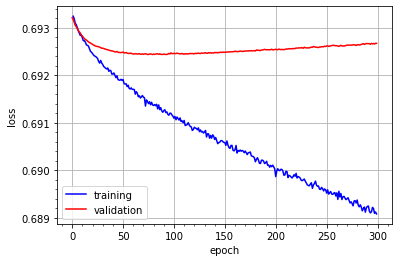

In [37]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()

In [38]:
valid_sets = []
with torch.no_grad():
    for xv1, xv2, yv in valid_dl:
        valid_sets.append([cnn_model(xv1,xv2).detach().cpu().numpy(), yv.detach().cpu().numpy()])

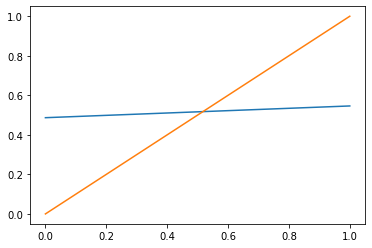

In [39]:
plt.figure()
plt.plot(valid_sets[1][0])
plt.plot(valid_sets[1][1])

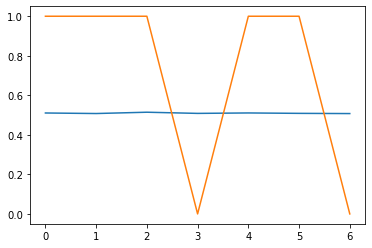

In [40]:
plt.figure()
plt.plot(pred.detach().cpu().numpy())
plt.plot(yb.detach().cpu().numpy())

In [108]:
h_ds

<xarray.Dataset>
Dimensions:         (hologram_number: 50000, particle: 500000, patch_number: 800000, patch_xsize: 128, patch_ysize: 128, xsize: 512, ysize: 512)
Dimensions without coordinates: hologram_number, particle, patch_number, patch_xsize, patch_ysize, xsize, ysize
Data variables: (12/16)
    hid             (particle) float32 1.0 1.0 1.0 1.0 ... 5e+04 5e+04 5e+04
    d               (particle) float32 36.48 45.38 25.82 ... 32.3 9.01 40.48
    x               (particle) float32 253.9 22.78 732.8 ... -616.6 -431.8
    y               (particle) float32 708.5 -600.7 552.2 ... 106.1 -190.7 662.5
    z               (particle) float32 5.645e+04 1.438e+05 ... 1.419e+05
    n0              (particle) float32 ...
    ...              ...
    x_pixels        (particle) float32 ...
    y_pixels        (particle) float32 ...
    pid             (particle) float32 ...
    x_patch_pixels  (particle) float32 ...
    y_patch_pixels  (particle) float32 ...
    patch           (patch_number, patch_xsize, patch_ysize) uint8 ...
Attributes: (12/33)
    DateCreated:           10-Feb-2021
    Nx:                    512.0
    Ny:                    512.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    monodisperse:          0.0
    should_cache:          1
    Nx_patch:              128.0
    Ny_patch:              128.0
    nPatches:              800000.0
    PatchesPerHologram:    16.0